In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../creme/')
import creme
import utils
import custom_model
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

2024-06-09 03:53:12.112293: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load Enformer and example sequences

In [2]:
track_index = [5111]
model = custom_model.Enformer(track_index=track_index)
target_df = pd.read_csv(f'../data/enformer_targets_human.txt', sep='\t')
cell_line_info = {i: [t, utils.clean_cell_name(target_df.iloc[t]['description'])] for i, t in
              enumerate(track_index)}

2024-06-09 03:53:13.448028: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-09 03:53:13.903910: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 58738 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:85:00.0, compute capability: 8.0


In [3]:
fasta_path = f'../data/GRCh38.primary_assembly.genome.fa'
seq_parser = utils.SequenceParser(fasta_path)

gene = 'GATA2_chr3_128487916_-'

gene_name, chrom, start, strand = gene.split('_')
wt_seq = seq_parser.extract_seq_centered(chrom, int(start), strand, model.seq_length)


In [4]:
# TSS bin indeces
bins = [447, 448]

In [5]:
wt = model.predict(wt_seq)[0,:,0]


2024-06-09 03:53:16.898851: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-06-09 03:53:17.021440: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401


<Axes: >

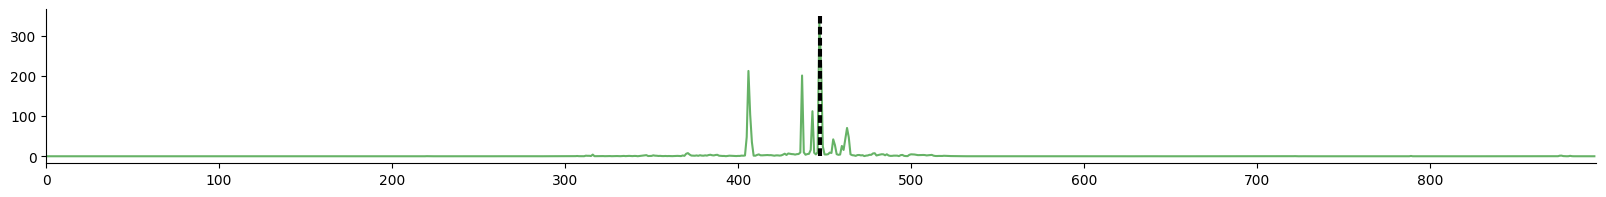

In [6]:
utils.plot_track([wt], color='green', zoom=[0, 896], marks=bins)


# Distance test
In this example we will test the distance effect of (5Kb) Enhancer CRE of the GATA2 gene. 

To run the test we need:
- a loaded model
- onehot encoded sequence (WT) of the sequence
- a list of fixed tile coordinates [start, end]
- a list of tile coordinates of the CRE
- tile coordinate test positions. These are where the CRE will be embedded to test distance-based effects.
- num_shuffle - number of shuffled
- optionally, we can set mean=False to not average the shuffle results
- optionally, we can set seed to use the same background sequences in each test position


In [7]:

perturb_window = 5000
N_shuffles = 10
tss_tile, cre_tiles = utils.set_tile_range(model.seq_length, perturb_window)
enhancing_cre_tile = cre_tiles[19]
print(f'Enhancing tile at position {enhancing_cre_tile[0]} - {enhancing_cre_tile[1]}')
print(f'TSS tile at center position {tss_tile[0]} - {tss_tile[1]}')

Enhancing tile at position 100804 - 105804
TSS tile at center position 95804 - 100804


In [8]:
test_start_positions = np.array(cre_tiles)[:,0]

## Distance effect of an enhancing tile of GATA2 gene TSS

In [9]:
%%time
results = creme.distance_test(model, wt_seq, tss_tile, enhancing_cre_tile, 
                                  test_start_positions, N_shuffles, mean=False, seed=True)

100%|███████████████████████████████████████████████████████████████████████████| 38/38 [02:14<00:00,  3.55s/it]

CPU times: user 40.2 s, sys: 318 ms, total: 40.5 s
Wall time: 2min 18s


## Breakdown of results

Text(0.5, 1.0, 'Mean of control sequences (CRE at original position)')

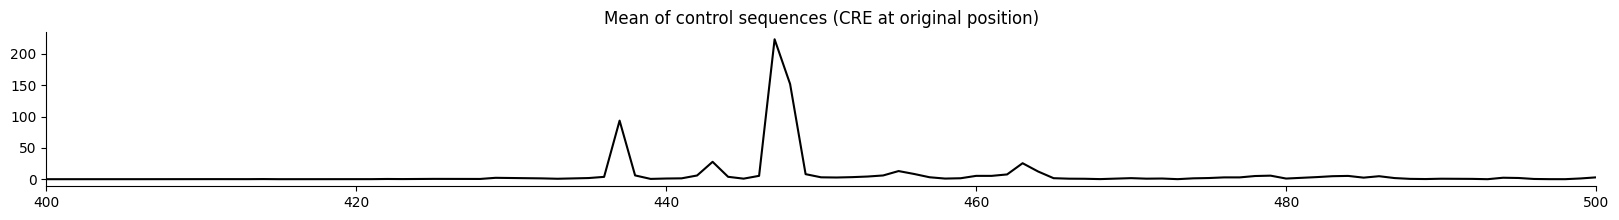

In [41]:
utils.plot_track([results['control'].mean(axis=0)[:,0]], zoom=[400,500], alpha=1, color='k')
plt.title('Mean of control sequences (CRE at original position)')

We can plot the mean prediction (across shuffles) for each test position.

/home/toneyan/paper_creme/creme-nn/tutorials/../creme/utils.py:327: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, figsize=[20, 2])


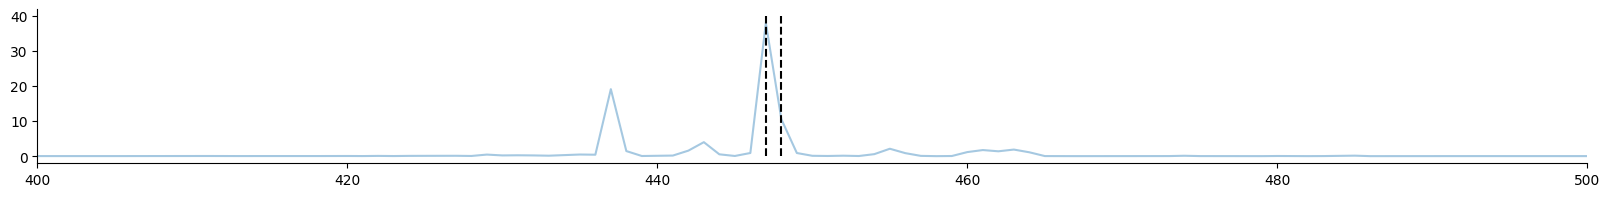

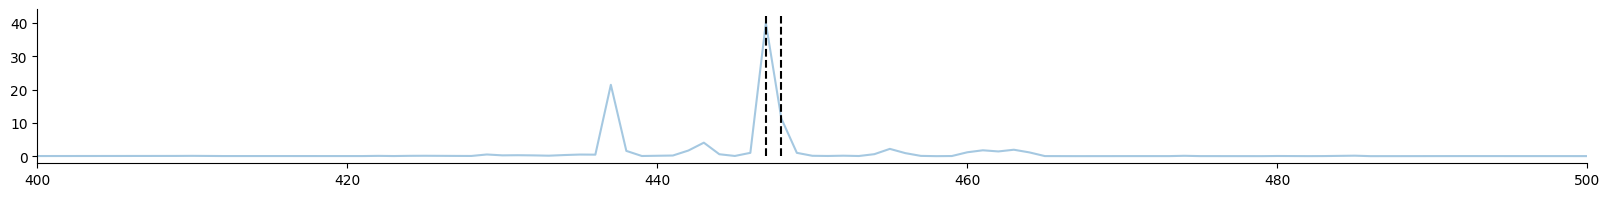

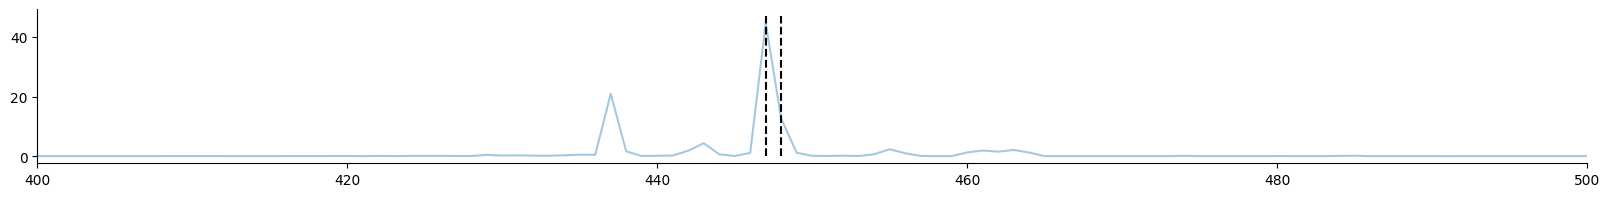

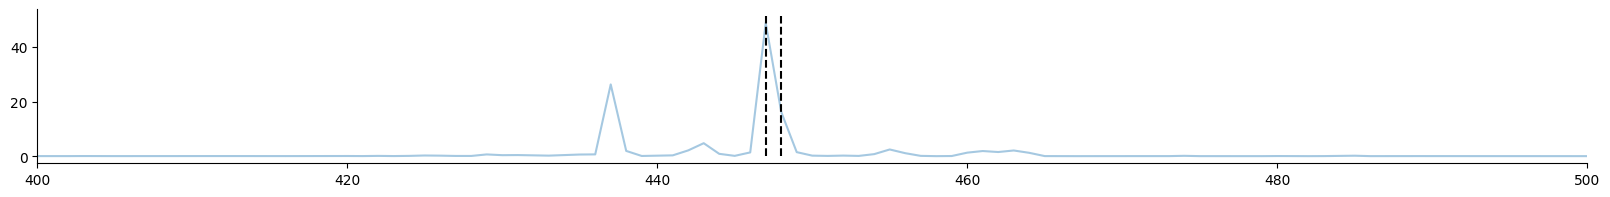

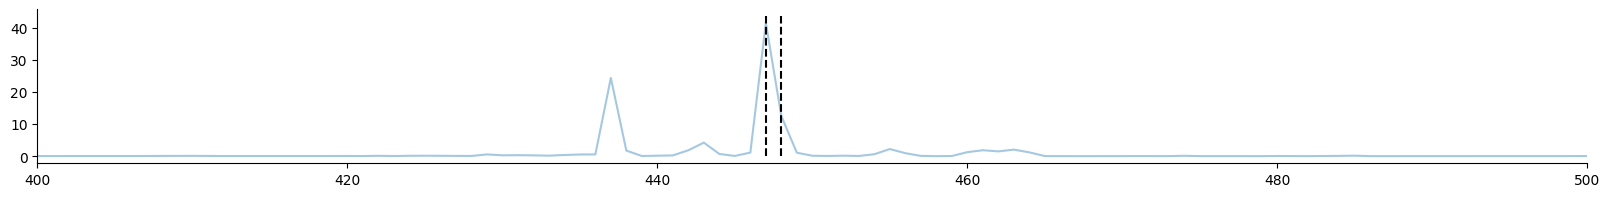

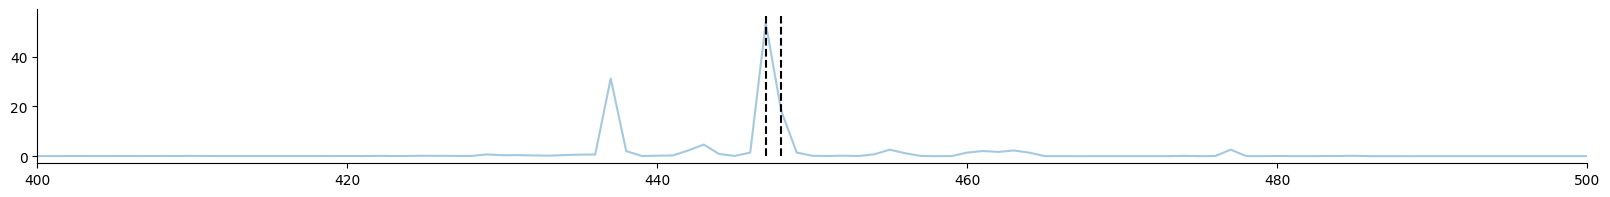

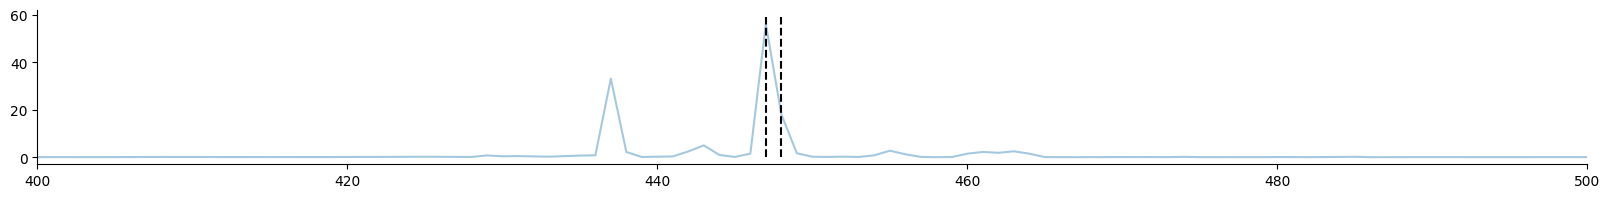

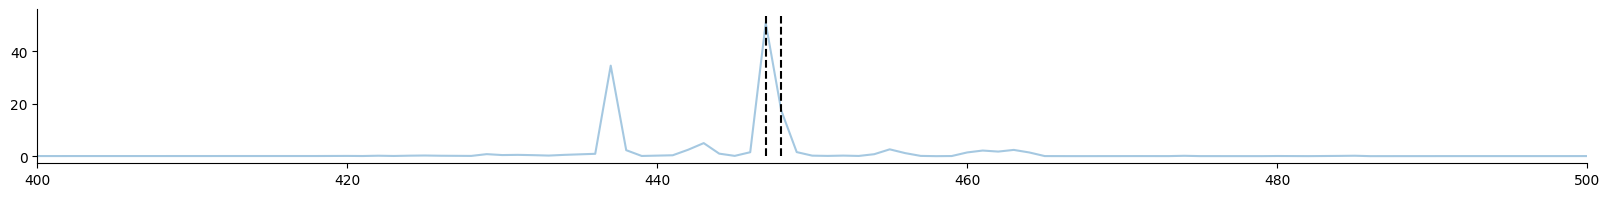

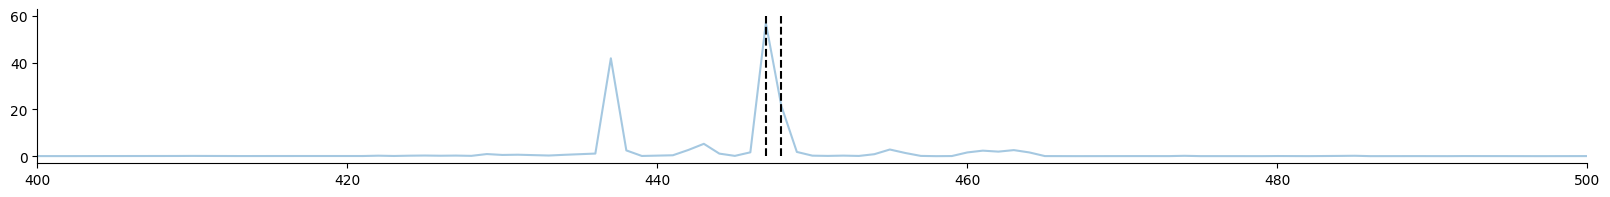

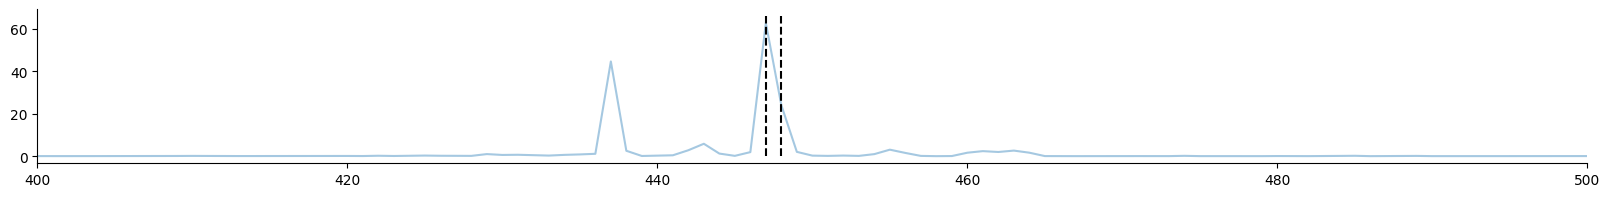

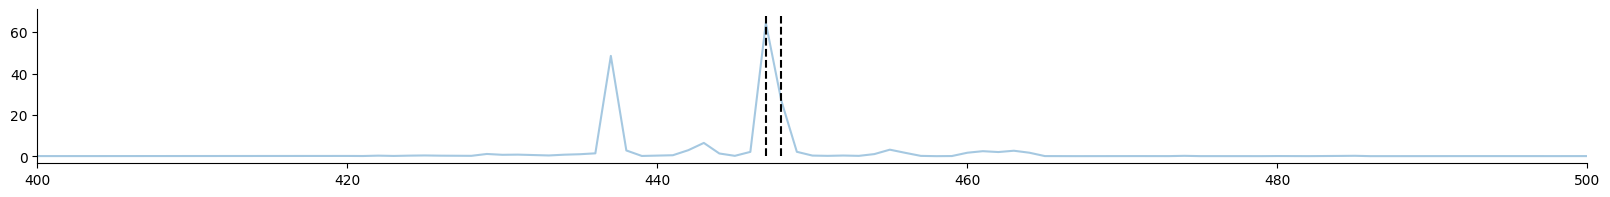

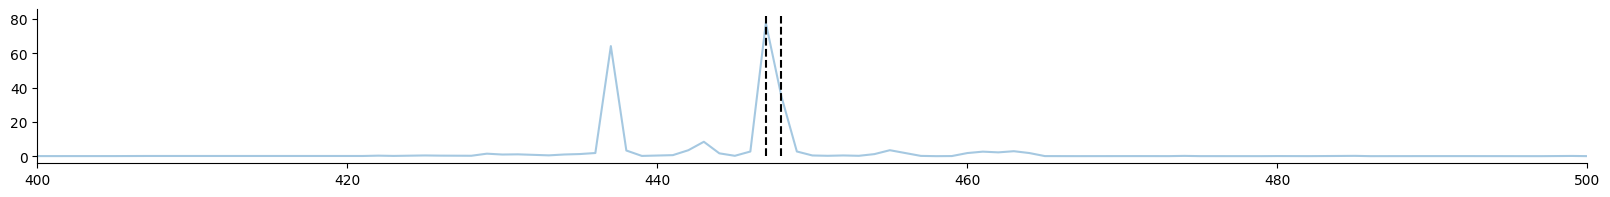

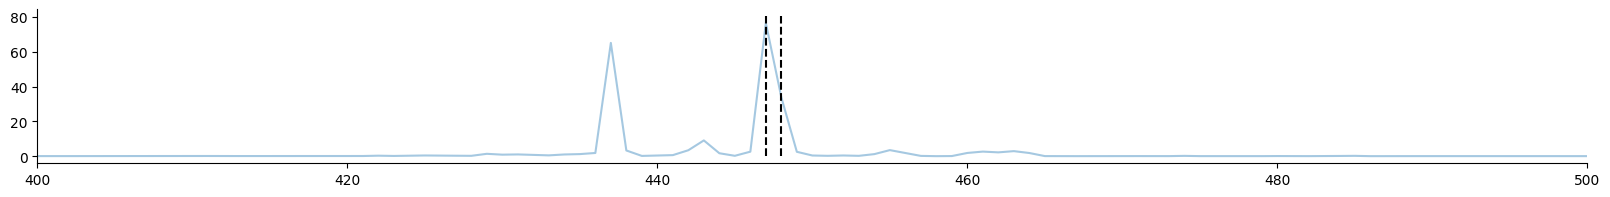

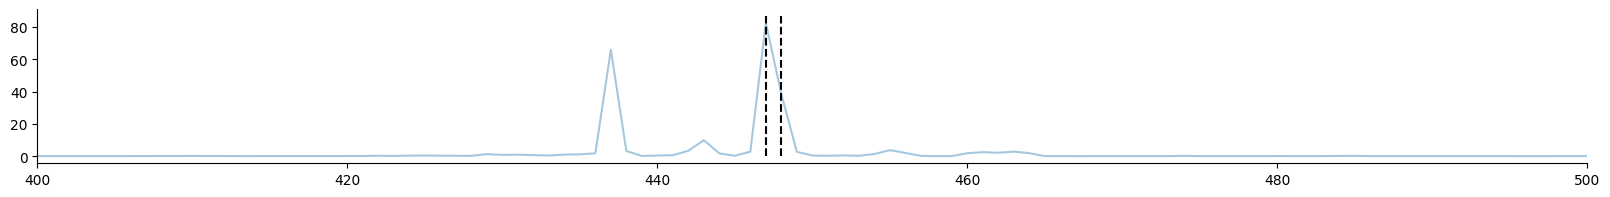

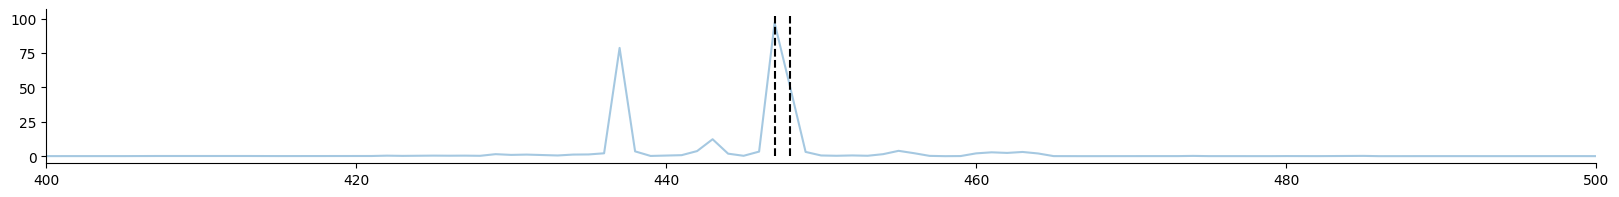

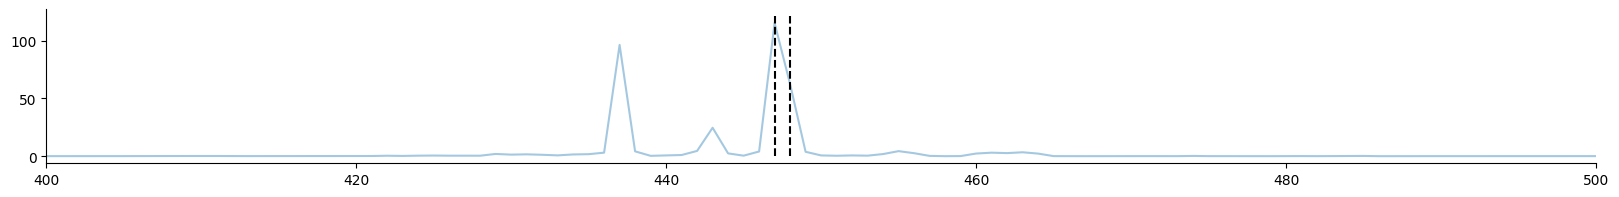

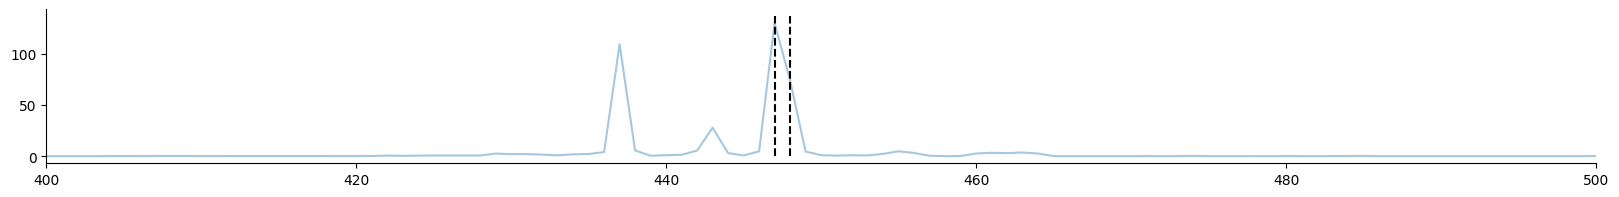

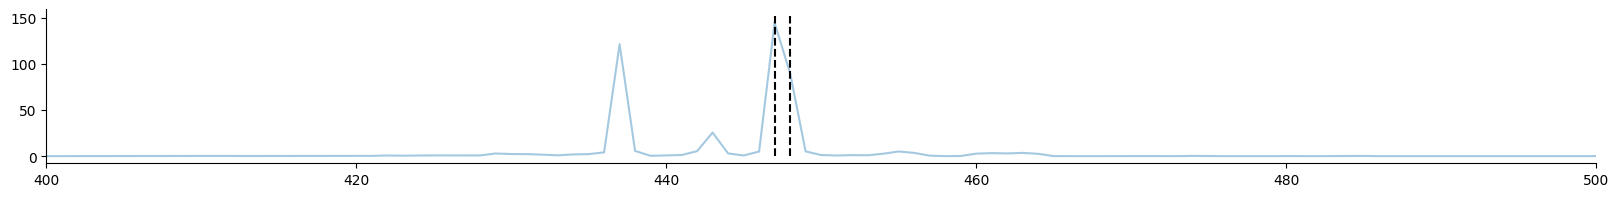

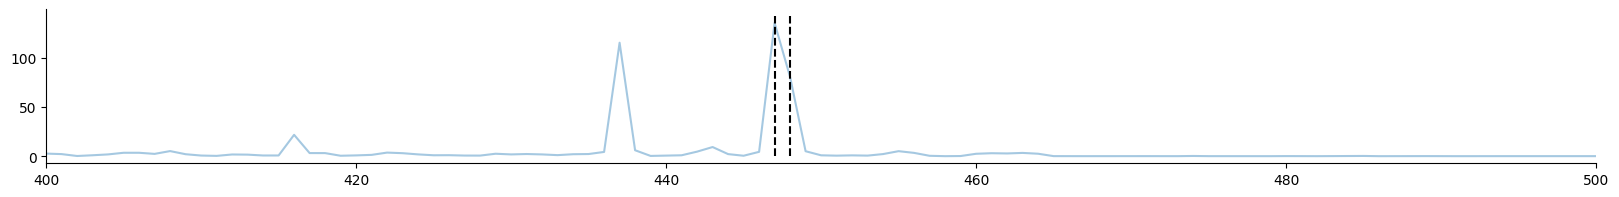

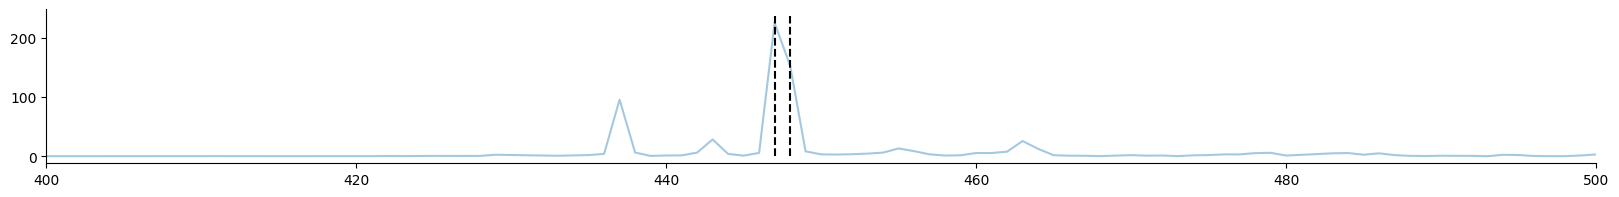

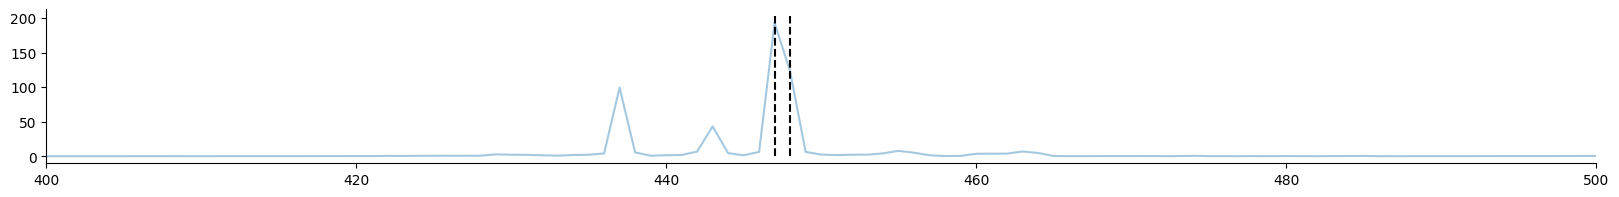

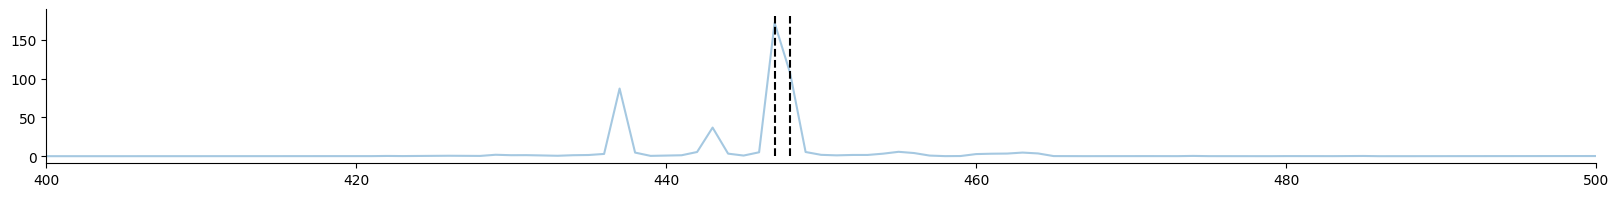

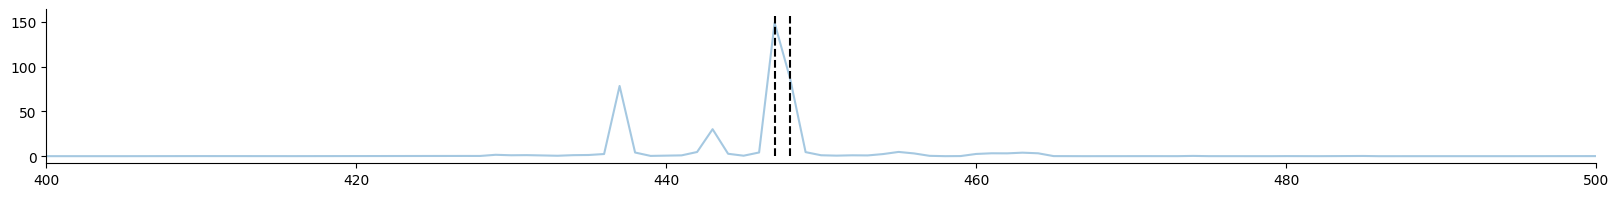

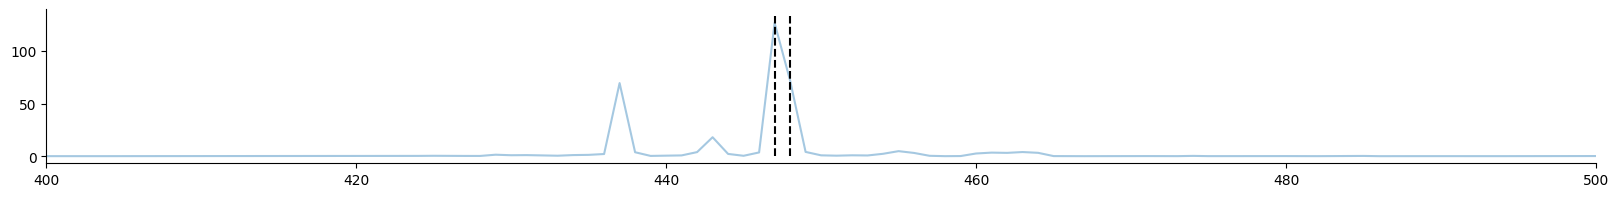

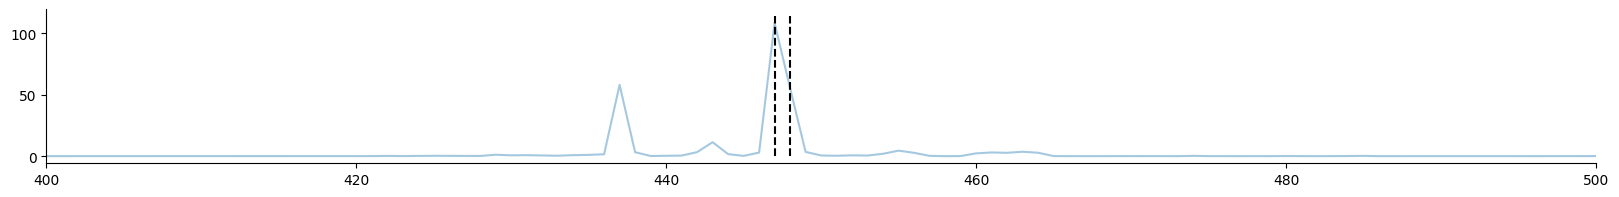

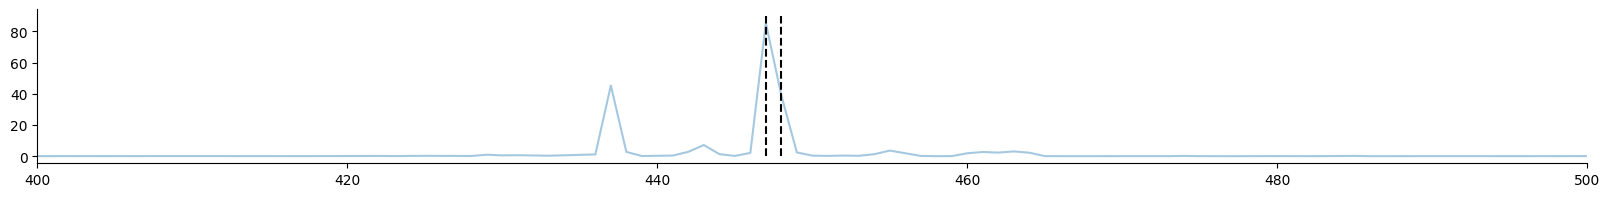

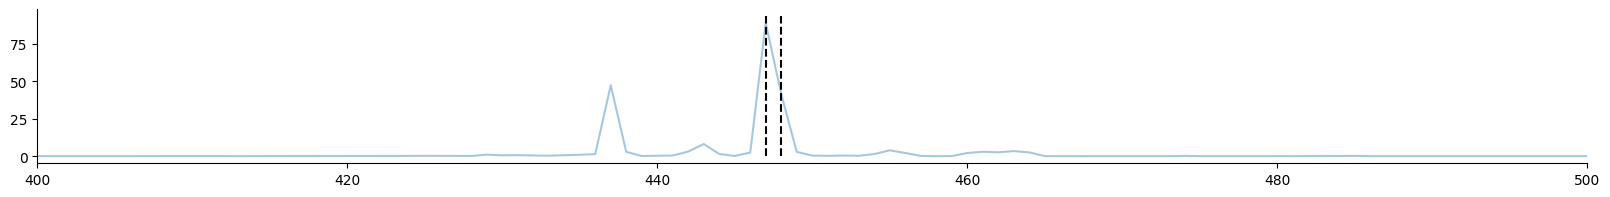

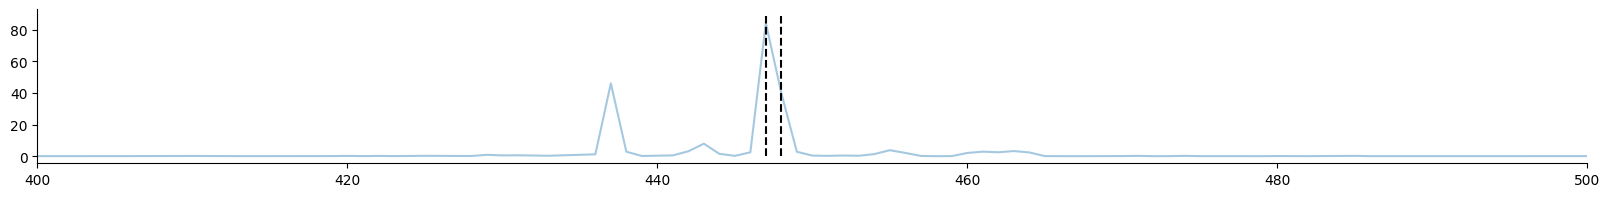

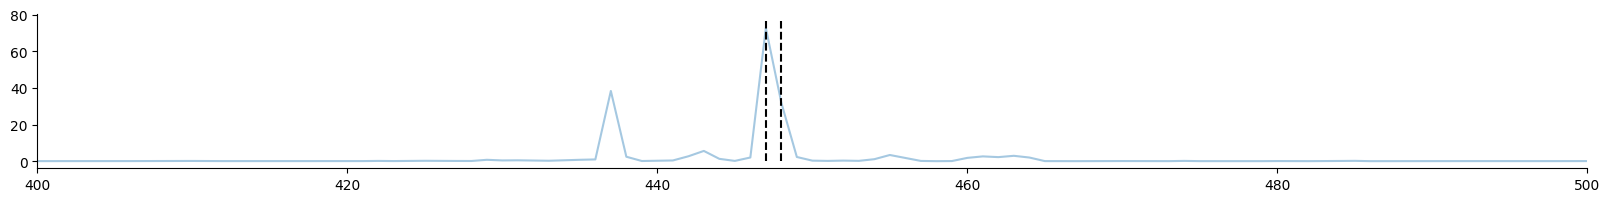

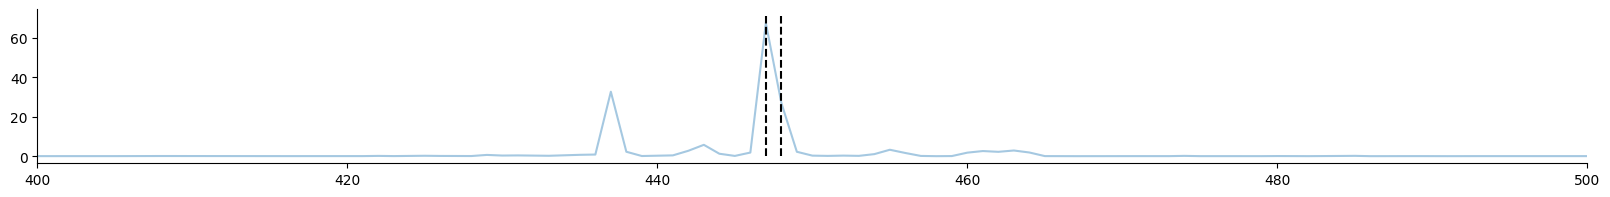

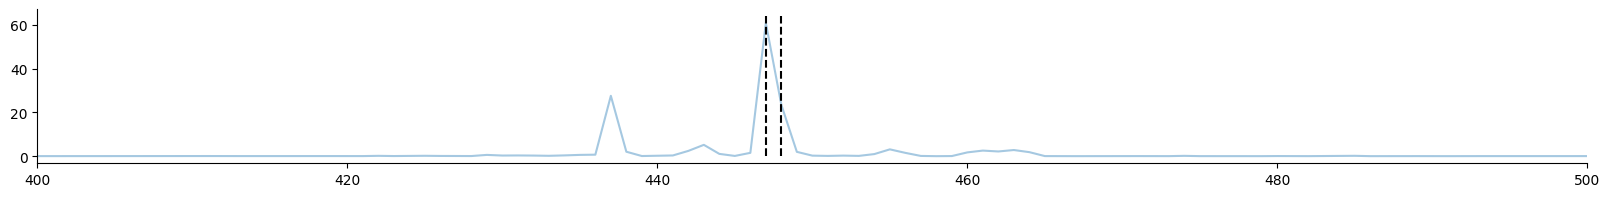

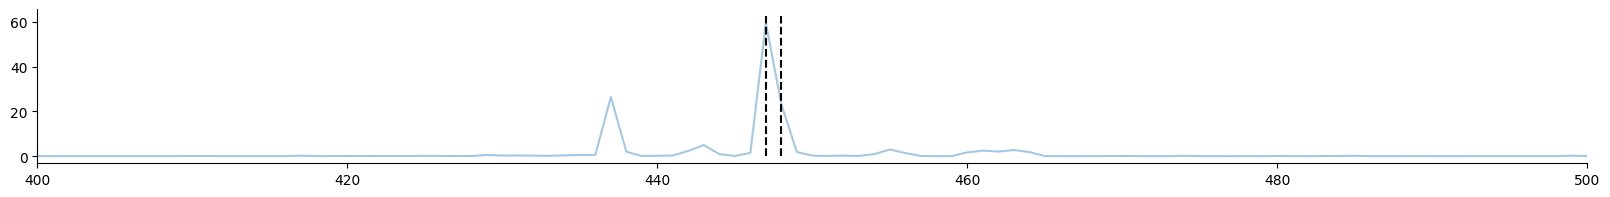

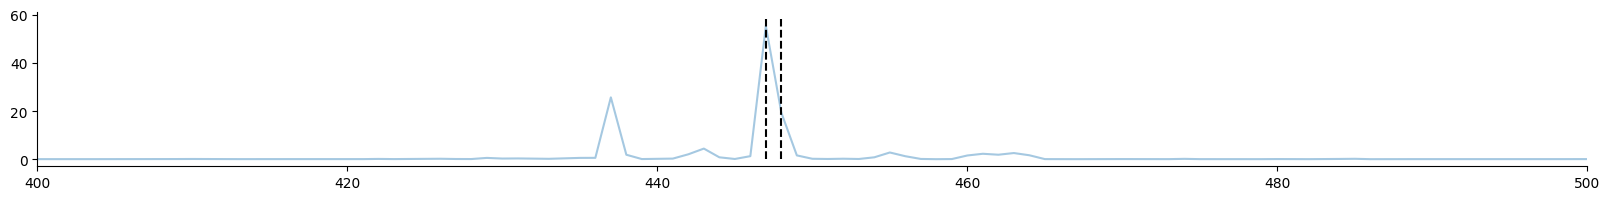

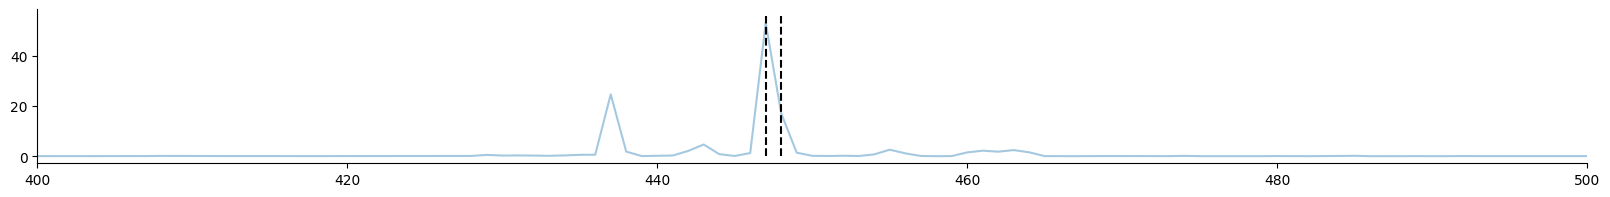

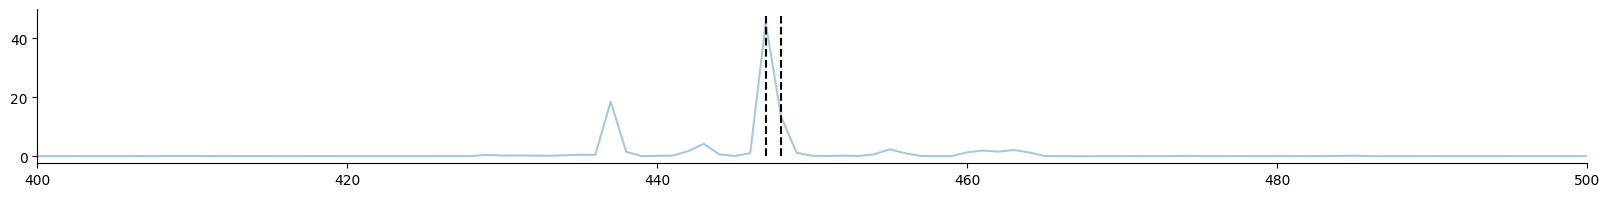

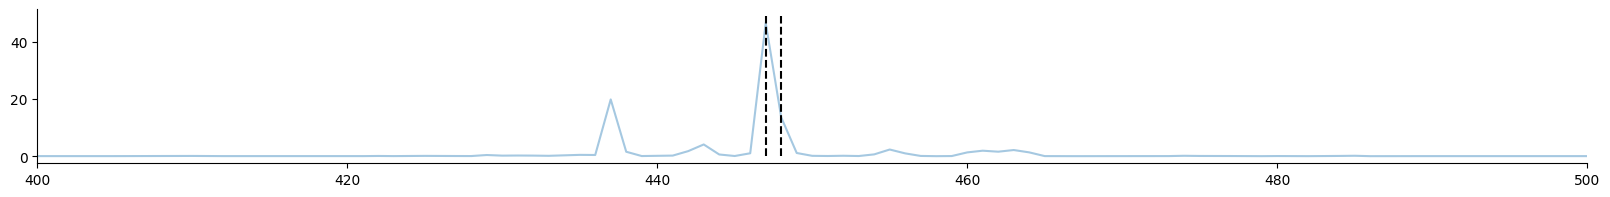

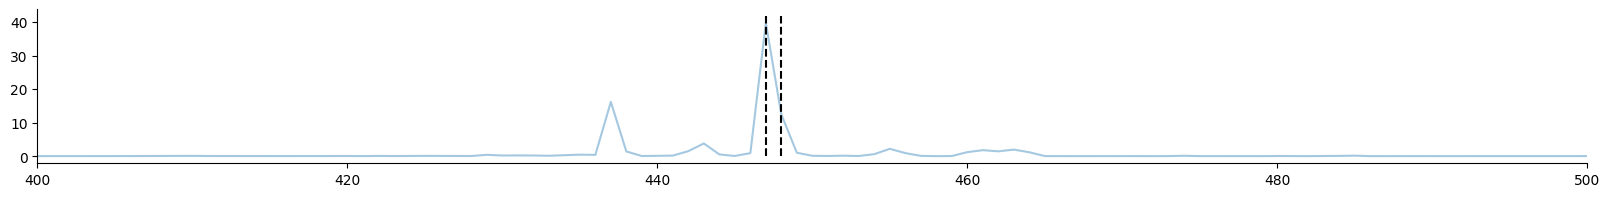

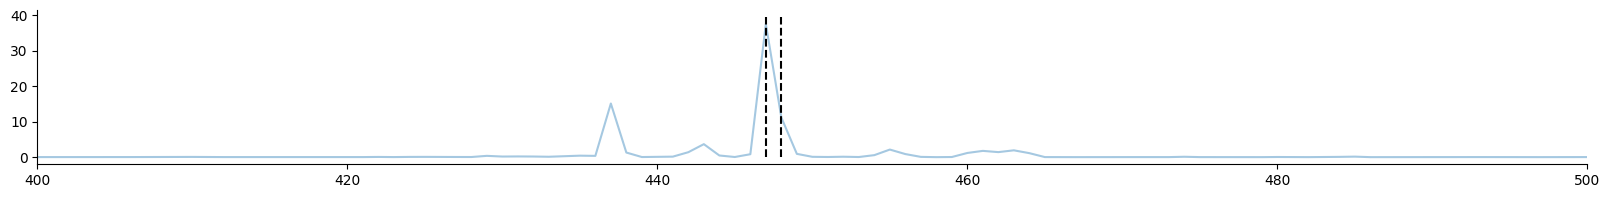

In [11]:
for one_position_result in results['mut'].mean(axis=1)[...,0]:
    utils.plot_track([one_position_result], zoom=[400,500], alpha=0.4, marks=[447, 448])

We can also plot the summary value of TSS activity (y-axis) versus the CRE position (x-axis) and select specific points to plot in detail.

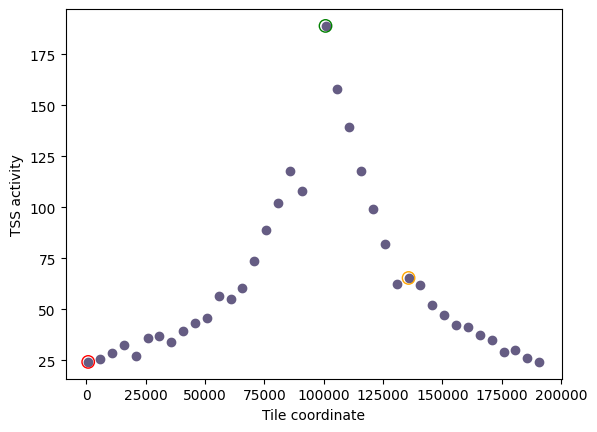

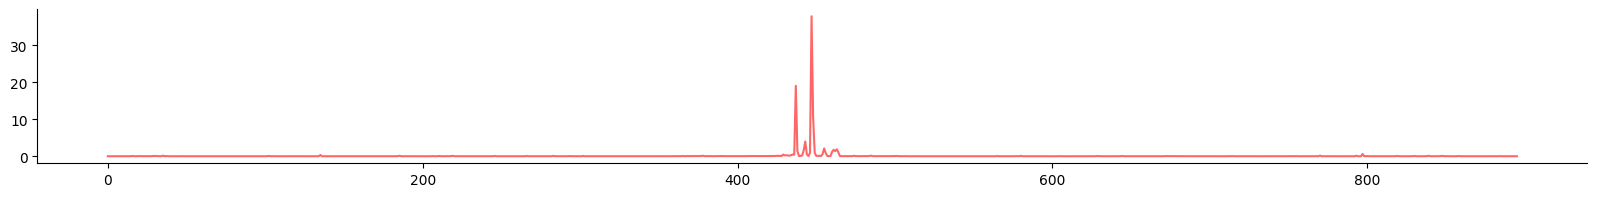

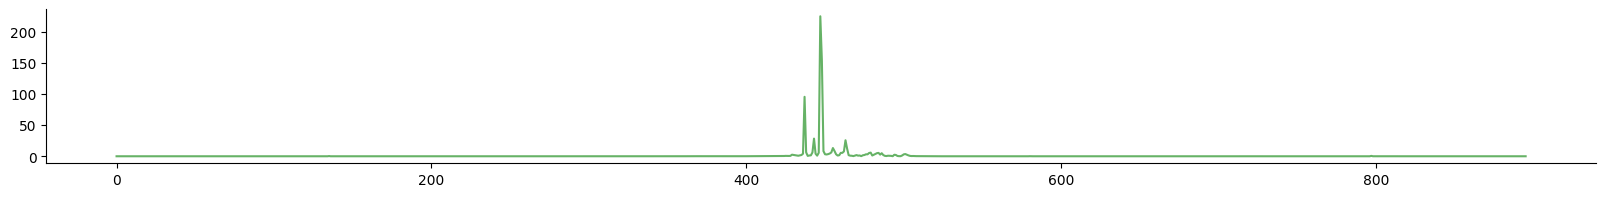

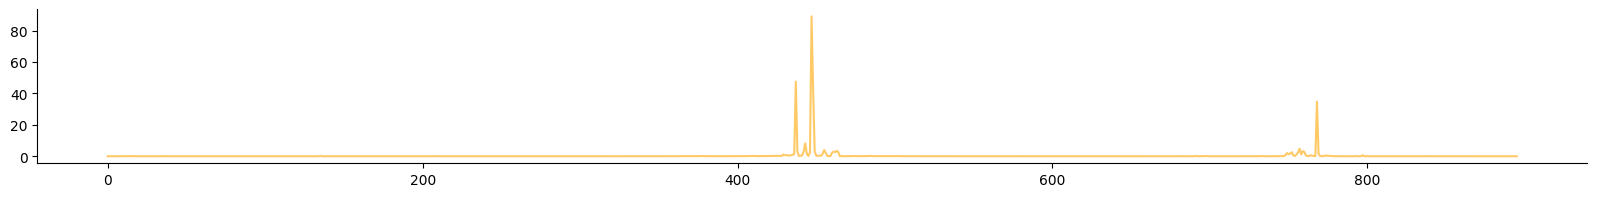

In [42]:
average_result_per_position = results['mut'].mean(axis=1)[...,0][:,[447, 448]].mean(axis=-1)
selection = [0, 19, 26]
colors = ['red', 'green', 'orange']
fig, ax = plt.subplots(1)

ax.scatter(test_start_positions, average_result_per_position, color='#655C83')

for i, selection in enumerate([0, 19, 26]):
    ax.scatter(test_start_positions[selection], average_result_per_position[selection],
               facecolors='none', edgecolors=colors[i], s=80);
    ax.set_xlabel('Tile coordinate')
    ax.set_ylabel('TSS activity')
    utils.plot_track([results['mut'].mean(axis=1)[selection,:,0]], color=colors[i])
